In [1]:
from keras import regularizers
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.layers import Input, Dense
from keras.layers.core import Activation
from keras.layers.recurrent import LSTM
from keras.models import Model, Sequential, load_model
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from scipy import stats
import tensorflow as tf

Using TensorFlow backend.


In [2]:
%matplotlib inline

import seaborn as sns
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

from pylab import rcParams
rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ["Inliers", "Outliers"]

### Load the data

In [192]:
df_all = pd.read_csv("/Users/t0272m1/Projects/HR Analytics/input/abs_jnap_20190204_model_daily_crew_pline_tbl_seq.csv")

In [193]:
df = df_all

In [148]:
df = df_all[(df_all['crew']=='A') & (df_all['production_line']=='Trim 1')]

In [194]:
df.shape

(37384, 53)

In [195]:
df.columns

Index(['workdate', 'crew', 'production_line', 'lost_hours', 'actual_hours',
       'paa_hours', 'absence_unplanned', 'absence_late', 'absence_noshow',
       'tardy_unplanned', 'high_absentee_count', 'streak_1', 'streak_2',
       'streak_3', 'streak_4_plus', 'cluster', 'au_rolling_5', 'au_rolling_12',
       'au_rolling_20', 'au_rolling_median_5', 'au_rolling_median_12',
       'au_rolling_median_20', 'actual_hours_rolling_mean_20',
       'actual_hours_rolling_median_20', 'lost_hours_rolling_mean_20',
       'lost_hours_rolling_median_20', 'kp_residual_5', 'kp_residual_12',
       'kp_residual_20', 'year', 'month', 'week', 'day', 'day_of_week',
       'day_of_year', 'quarter', 'next_day_delta', 'chrysler_holiday_delta',
       'chrysler_holiday_day_before', 'chrysler_holiday_day_after',
       'federal_holiday_delta', 'federal_holiday_day_before',
       'federal_holiday_day_of', 'federal_holiday_day_after',
       'event_day_delta', 'precip', 'snowfall', 'snow_depth', 'temp_avg',
  

In [196]:
target = 'absence_unplanned'

In [197]:
df[target].describe()

count    37384.000000
mean         5.857773
std          4.045870
min          0.000000
25%          3.000000
50%          5.000000
75%          8.000000
max         38.000000
Name: absence_unplanned, dtype: float64

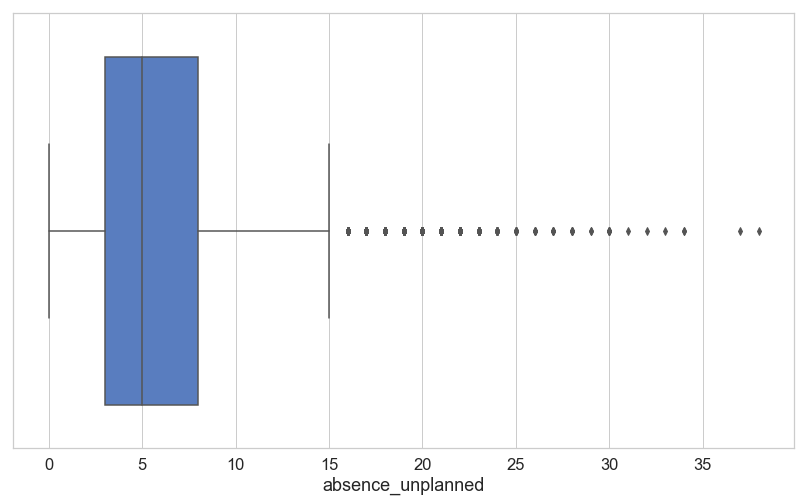

In [198]:
ax = sns.boxplot(x=df[target])

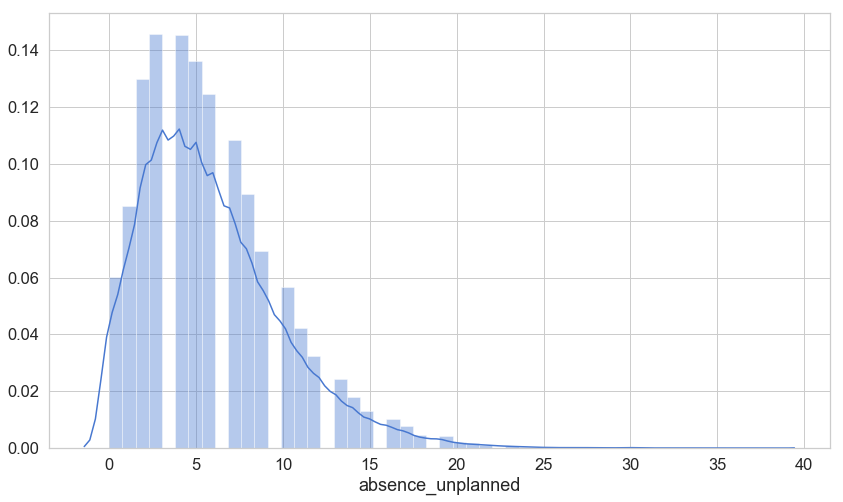

In [199]:
ax = sns.distplot(df[target])

### Outlier Analysis

In [200]:
target_mean = df[target].mean()
print(target_mean)
target_std = df[target].std()
print(target_std)

5.857773378985662
4.045870196423954


In [201]:
nstd = 2.0
lower_bound = round(target_mean + (nstd * target_std))
print(lower_bound)

14.0


In [202]:
len(df[df[target] >= lower_bound])

1860

In [203]:
# now shift target to outliers
target = 'outlier'

In [204]:
df[target] = (df['absence_unplanned'] >= lower_bound).astype(int)

In [205]:
df[df[target] == 1]

,workdate,crew,production_line,lost_hours,actual_hours,paa_hours,absence_unplanned,absence_late,absence_noshow,tardy_unplanned,...,event_day_delta,precip,snowfall,snow_depth,temp_avg,temp_max,temp_min,fog,temp_delta,outlier
70,2014-01-06,A,Chassis 1 & 2,33.2,1287.7,58.0,20,7.0,3.0,7.0,...,-735,0.06,0.8,16.1,13.0,20.0,-14.0,0.0,5.0,1
79,2014-01-06,A,Trim 1,90.0,1383.2,20.0,17,0.0,9.0,0.0,...,-735,0.06,0.8,16.1,13.0,20.0,-14.0,0.0,5.0,1
87,2014-01-06,C,Material,41.0,1077.7,10.0,19,1.0,4.0,1.0,...,-735,0.06,0.8,16.1,13.0,20.0,-14.0,0.0,-11.0,1
92,2014-01-07,A,Chassis 1 & 2,184.9,480.8,30.0,15,2.0,18.0,2.0,...,-734,0.00,0.0,16.1,-10.0,-1.0,-14.0,0.0,-21.0,1
106,2014-01-07,C,Engine Line,52.5,222.3,0.0,21,2.0,5.0,2.0,...,-734,0.00,0.0,16.1,-10.0,-1.0,-14.0,0.0,-21.0,1
109,2014-01-07,C,Material,154.6,464.2,0.0,19,4.0,15.0,4.0,...,-734,0.00,0.0,16.1,-10.0,-1.0,-14.0,0.0,-21.0,1
112,2014-01-07,C,Trim 1,100.0,545.1,0.0,24,0.0,10.0,0.0,...,-734,0.00,0.0,16.1,-10.0,-1.0,-14.0,0.0,-21.0,1
125,2014-01-08,B,Chassis 1 & 2,10.0,1294.8,10.0,14,0.0,1.0,0.0,...,-733,0.00,0.0,15.0,2.0,16.0,-7.0,0.0,-15.0,1
131,2014-01-08,B,Material,20.2,1096.2,10.0,14,1.0,2.0,1.0,...,-733,0.00,0.0,15.0,2.0,16.0,-7.0,0.0,-15.0,1
134,2014-01-08,B,Trim 1,70.0,1381.4,4.0,20,0.0,7.0,0.0,...,-733,0.00,0.0,15.0,2.0,16.0,-7.0,0.0,-15.0,1


### Exploration

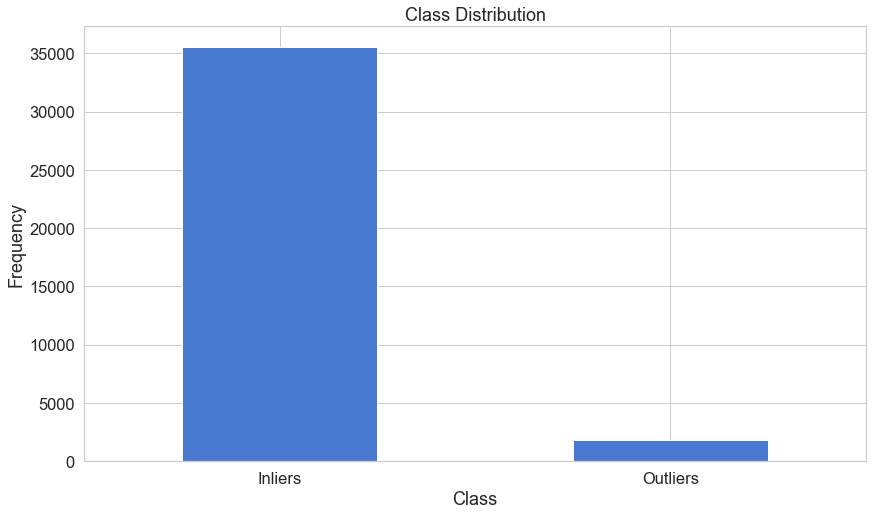

In [206]:
count_classes = pd.value_counts(df[target], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Class Distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

Note the highly imbalanced dataset.

In [207]:
outliers = df[df[target] == 1]
inliers = df[df[target] == 0]

In [208]:
outliers.shape

(1860, 54)

In [209]:
inliers.shape

(35524, 54)

### Data Preparation

In [210]:
df.columns

Index(['workdate', 'crew', 'production_line', 'lost_hours', 'actual_hours',
       'paa_hours', 'absence_unplanned', 'absence_late', 'absence_noshow',
       'tardy_unplanned', 'high_absentee_count', 'streak_1', 'streak_2',
       'streak_3', 'streak_4_plus', 'cluster', 'au_rolling_5', 'au_rolling_12',
       'au_rolling_20', 'au_rolling_median_5', 'au_rolling_median_12',
       'au_rolling_median_20', 'actual_hours_rolling_mean_20',
       'actual_hours_rolling_median_20', 'lost_hours_rolling_mean_20',
       'lost_hours_rolling_median_20', 'kp_residual_5', 'kp_residual_12',
       'kp_residual_20', 'year', 'month', 'week', 'day', 'day_of_week',
       'day_of_year', 'quarter', 'next_day_delta', 'chrysler_holiday_delta',
       'chrysler_holiday_day_before', 'chrysler_holiday_day_after',
       'federal_holiday_delta', 'federal_holiday_day_before',
       'federal_holiday_day_of', 'federal_holiday_day_after',
       'event_day_delta', 'precip', 'snowfall', 'snow_depth', 'temp_avg',
  

In [211]:
for f in df.columns:
    print("Feature %s, Type %s" % (f, df[f].dtypes))

Feature workdate, Type object
Feature crew, Type object
Feature production_line, Type object
Feature lost_hours, Type float64
Feature actual_hours, Type float64
Feature paa_hours, Type float64
Feature absence_unplanned, Type int64
Feature absence_late, Type float64
Feature absence_noshow, Type float64
Feature tardy_unplanned, Type float64
Feature high_absentee_count, Type float64
Feature streak_1, Type float64
Feature streak_2, Type float64
Feature streak_3, Type float64
Feature streak_4_plus, Type float64
Feature cluster, Type float64
Feature au_rolling_5, Type float64
Feature au_rolling_12, Type float64
Feature au_rolling_20, Type float64
Feature au_rolling_median_5, Type float64
Feature au_rolling_median_12, Type float64
Feature au_rolling_median_20, Type float64
Feature actual_hours_rolling_mean_20, Type float64
Feature actual_hours_rolling_median_20, Type float64
Feature lost_hours_rolling_mean_20, Type float64
Feature lost_hours_rolling_median_20, Type float64
Feature kp_residual

In [212]:
drop_cols = ['workdate', 'ch_dept', 'production_line', 'crew']
df.drop(columns=drop_cols, inplace=True, errors='ignore')

In [213]:
df.columns

Index(['lost_hours', 'actual_hours', 'paa_hours', 'absence_unplanned',
       'absence_late', 'absence_noshow', 'tardy_unplanned',
       'high_absentee_count', 'streak_1', 'streak_2', 'streak_3',
       'streak_4_plus', 'cluster', 'au_rolling_5', 'au_rolling_12',
       'au_rolling_20', 'au_rolling_median_5', 'au_rolling_median_12',
       'au_rolling_median_20', 'actual_hours_rolling_mean_20',
       'actual_hours_rolling_median_20', 'lost_hours_rolling_mean_20',
       'lost_hours_rolling_median_20', 'kp_residual_5', 'kp_residual_12',
       'kp_residual_20', 'year', 'month', 'week', 'day', 'day_of_week',
       'day_of_year', 'quarter', 'next_day_delta', 'chrysler_holiday_delta',
       'chrysler_holiday_day_before', 'chrysler_holiday_day_after',
       'federal_holiday_delta', 'federal_holiday_day_before',
       'federal_holiday_day_of', 'federal_holiday_day_after',
       'event_day_delta', 'precip', 'snowfall', 'snow_depth', 'temp_avg',
       'temp_max', 'temp_min', 'fog', 'te

#### Standard Scaling

In [214]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [215]:
scols = df.columns.tolist()
scols.remove(target)
df[scols] = scaler.fit_transform(df[scols])

C:\Users\t0272m1\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\t0272m1\anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [216]:
df.dropna(inplace=True)

In [217]:
df.head(20)

,lost_hours,actual_hours,paa_hours,absence_unplanned,absence_late,absence_noshow,tardy_unplanned,high_absentee_count,streak_1,streak_2,...,event_day_delta,precip,snowfall,snow_depth,temp_avg,temp_max,temp_min,fog,temp_delta,outlier
6,-1.348319,-2.376006,-0.805942,0.035154,-0.923920,-1.324538,-0.923920,-1.211049,-1.313969,-0.834798,...,-2.740970,0.204604,6.708251,2.794262,-1.922317,-2.126315,-2.029157,-0.942583,-0.212476,0
10,-1.348319,-2.386670,-0.805942,-0.212015,-0.923920,-1.324538,-0.923920,-0.094131,-1.313969,-0.834798,...,-2.740970,0.204604,6.708251,2.794262,-1.922317,-2.126315,-2.029157,-0.942583,-0.212476,0
11,-1.348319,-2.277083,-0.805942,-0.953522,-0.923920,-1.324538,-0.923920,-0.856472,-1.313969,-0.834798,...,-2.740970,0.204604,6.708251,2.794262,-1.922317,-2.126315,-2.029157,-0.942583,-0.212476,0
13,-1.348319,-2.389980,-0.805942,0.776661,-0.923920,-1.324538,-0.923920,0.490921,-1.313969,-0.834798,...,-2.740970,0.204604,6.708251,2.794262,-1.922317,-2.126315,-2.029157,-0.942583,-0.212476,0
26,-1.342363,1.616202,0.159985,-0.706353,-0.295459,-1.324538,-0.295459,0.207259,-0.990759,-0.834798,...,-2.736452,-0.349630,-0.201210,2.187786,-2.434600,-2.267614,-2.501525,-0.942583,-0.318773,0
27,-1.339384,-0.349747,-0.805942,-1.447860,0.333003,-1.324538,0.333003,-1.122405,-0.667548,-0.834798,...,-2.736452,-0.349630,-0.201210,2.187786,-2.434600,-2.267614,-2.501525,-0.942583,-0.318773,0
28,-1.348319,-0.726682,-0.805942,-1.447860,-0.923920,-1.324538,-0.923920,-1.228778,-1.313969,-0.834798,...,-2.736452,-0.349630,-0.201210,2.187786,-2.434600,-2.267614,-2.501525,-0.942583,-0.318773,0
29,-0.454809,-0.054082,-0.161991,-0.953522,-0.923920,-0.418804,-0.923920,-0.767828,-0.344337,-0.834798,...,-2.736452,-0.349630,-0.201210,2.187786,-2.434600,-2.267614,-2.501525,-0.942583,-0.318773,0
30,-0.728819,-0.068792,-0.805942,-0.706353,0.333003,-0.720715,0.333003,-0.679184,-0.021126,-0.834798,...,-2.736452,-0.349630,-0.201210,2.187786,-2.434600,-2.267614,-2.501525,-0.942583,-0.318773,0
31,-0.752646,-0.586573,0.481961,-0.953522,-0.923920,-0.720715,-0.923920,-1.122405,-0.667548,-0.834798,...,-2.736452,-0.349630,-0.201210,2.187786,-2.434600,-2.267614,-2.501525,-0.942583,-0.318773,0


### Train and Test

In [218]:
from sklearn.model_selection import train_test_split

In [219]:
split = 0.2
X_train, X_test = train_test_split(df, test_size=split, random_state=RANDOM_SEED)
print(X_train.shape, X_test.shape)

(29876, 51) (7469, 51)


In [220]:
X_train = X_train[X_train[target] == 0]
X_train = X_train.drop([target], axis=1)

y_test = X_test[target]
X_test = X_test.drop([target], axis=1)

X_train.shape, X_test.shape, y_test.shape

((28371, 50), (7469, 50), (7469,))

In [221]:
X_train = X_train.values
X_test = X_test.values

In [222]:
X_train.shape, X_test.shape

((28371, 50), (7469, 50))

### Build the Model

#### AutoEncoder 1 (Non-LSTM)

This autoencoder uses 4 fully connected layers with 14, 7, 7 and 29 neurons respectively.  The first two layers are used for our encoder, the last two go for the decoder. Additionally, L1 regularization will be used during training.

In [223]:
input_dim = X_train.shape[1]
input_layer = Input(shape=(input_dim, ))

In [224]:
encoding_dim = 14
batch_size = 32

encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

#### AutoEncoder 2 (LSTM)

In [ ]:
use_lstm = False
if use_lstm:
    X_train = X_train.reshape(1, X_train.shape[0], X_train.shape[1])
    X_test = X_test.reshape(1, X_test.shape[0], X_test.shape[1])
    X_train.shape, X_test.shape

In [ ]:
if use_lstm:
    lstm_dim = 50
    batch_size = 1

    autoencoder = Sequential()
    autoencoder.add(LSTM(lstm_dim, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
    autoencoder.add(LSTM(lstm_dim))
    autoencoder.add(Activation('linear'))

#### Model Training

In [225]:
nb_epoch = 1000

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)

tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Train on 28371 samples, validate on 7469 samples
Epoch 1/1000
28371/28371 [==============================] - 2s 67us/step - loss: 0.8091 - acc: 0.1076 - val_loss: 0.7335 - val_acc: 0.1688
Epoch 2/1000
28371/28371 [==============================] - 2s 61us/step - loss: 0.6923 - acc: 0.1963 - val_loss: 0.6739 - val_acc: 0.2386
Epoch 3/1000
28371/28371 [==============================] - 2s 62us/step - loss: 0.6480 - acc: 0.2560 - val_loss: 0.6403 - val_acc: 0.2794
Epoch 4/1000
28371/28371 [==============================] - 2s 60us/step - loss: 0.6177 - acc: 0.2915 - val_loss: 0.6152 - val_acc: 0.2943
Epoch 5/1000
28371/28371 [==============================] - 2s 68us/step - loss: 0.5972 - acc: 0.2999 - val_loss: 0.6002 - val_acc: 0.3067
Epoch 6/1000
28371/28371 [==============================] - 2s 63us/step - loss: 0.5841 - acc: 0.3126 - val_loss: 0.5892 - val_acc: 0.3165
Epoch 7/1000
28371/28371 [==============================] - 2s 58us/step - loss: 0.5750 - acc: 0.3232 - val_loss: 0.5

28371/28371 [==============================] - 1s 46us/step - loss: 0.5275 - acc: 0.3757 - val_loss: 0.5365 - val_acc: 0.3731
Epoch 118/1000
28371/28371 [==============================] - 1s 47us/step - loss: 0.5275 - acc: 0.3740 - val_loss: 0.5378 - val_acc: 0.3697
Epoch 119/1000
28371/28371 [==============================] - 1s 46us/step - loss: 0.5274 - acc: 0.3740 - val_loss: 0.5369 - val_acc: 0.3685
Epoch 120/1000
28371/28371 [==============================] - 1s 48us/step - loss: 0.5274 - acc: 0.3758 - val_loss: 0.5369 - val_acc: 0.3648
Epoch 121/1000
28371/28371 [==============================] - 1s 45us/step - loss: 0.5274 - acc: 0.3752 - val_loss: 0.5363 - val_acc: 0.3713
Epoch 122/1000
28371/28371 [==============================] - 1s 47us/step - loss: 0.5273 - acc: 0.3744 - val_loss: 0.5362 - val_acc: 0.3703
Epoch 123/1000
28371/28371 [==============================] - 1s 47us/step - loss: 0.5273 - acc: 0.3735 - val_loss: 0.5369 - val_acc: 0.3599
Epoch 124/1000
28371/28371 [

28371/28371 [==============================] - 1s 47us/step - loss: 0.5239 - acc: 0.3840 - val_loss: 0.5327 - val_acc: 0.3770
Epoch 233/1000
28371/28371 [==============================] - 1s 47us/step - loss: 0.5240 - acc: 0.3849 - val_loss: 0.5331 - val_acc: 0.3877
Epoch 234/1000
28371/28371 [==============================] - 1s 47us/step - loss: 0.5240 - acc: 0.3861 - val_loss: 0.5342 - val_acc: 0.3813
Epoch 235/1000
28371/28371 [==============================] - 1s 47us/step - loss: 0.5241 - acc: 0.3872 - val_loss: 0.5337 - val_acc: 0.3693
Epoch 236/1000
28371/28371 [==============================] - 1s 48us/step - loss: 0.5238 - acc: 0.3864 - val_loss: 0.5330 - val_acc: 0.3825
Epoch 237/1000
28371/28371 [==============================] - 1s 46us/step - loss: 0.5239 - acc: 0.3861 - val_loss: 0.5346 - val_acc: 0.3760
Epoch 238/1000
28371/28371 [==============================] - 1s 48us/step - loss: 0.5239 - acc: 0.3859 - val_loss: 0.5329 - val_acc: 0.3885
Epoch 239/1000
28371/28371 [

Epoch 290/1000
28371/28371 [==============================] - 1s 46us/step - loss: 0.5230 - acc: 0.3910 - val_loss: 0.5327 - val_acc: 0.3857
Epoch 291/1000
28371/28371 [==============================] - 1s 46us/step - loss: 0.5231 - acc: 0.3916 - val_loss: 0.5339 - val_acc: 0.3825
Epoch 292/1000
28371/28371 [==============================] - 1s 46us/step - loss: 0.5231 - acc: 0.3876 - val_loss: 0.5323 - val_acc: 0.3837
Epoch 293/1000
28371/28371 [==============================] - 1s 47us/step - loss: 0.5230 - acc: 0.3923 - val_loss: 0.5324 - val_acc: 0.3797
Epoch 294/1000
28371/28371 [==============================] - 1s 47us/step - loss: 0.5231 - acc: 0.3907 - val_loss: 0.5324 - val_acc: 0.3794
Epoch 295/1000
28371/28371 [==============================] - 1s 48us/step - loss: 0.5230 - acc: 0.3909 - val_loss: 0.5325 - val_acc: 0.4014
Epoch 296/1000
28371/28371 [==============================] - 1s 46us/step - loss: 0.5229 - acc: 0.3946 - val_loss: 0.5327 - val_acc: 0.3781
Epoch 297/100

Epoch 348/1000
28371/28371 [==============================] - 1s 48us/step - loss: 0.5226 - acc: 0.3936 - val_loss: 0.5340 - val_acc: 0.3885
Epoch 349/1000
28371/28371 [==============================] - 1s 45us/step - loss: 0.5226 - acc: 0.3959 - val_loss: 0.5324 - val_acc: 0.3766
Epoch 350/1000
28371/28371 [==============================] - 1s 45us/step - loss: 0.5226 - acc: 0.3938 - val_loss: 0.5317 - val_acc: 0.3853
Epoch 351/1000
28371/28371 [==============================] - 1s 47us/step - loss: 0.5226 - acc: 0.3943 - val_loss: 0.5317 - val_acc: 0.3960
Epoch 352/1000
28371/28371 [==============================] - 1s 46us/step - loss: 0.5225 - acc: 0.3931 - val_loss: 0.5320 - val_acc: 0.3867
Epoch 353/1000
28371/28371 [==============================] - ETA: 0s - loss: 0.5227 - acc: 0.393 - 1s 47us/step - loss: 0.5227 - acc: 0.3936 - val_loss: 0.5317 - val_acc: 0.3954
Epoch 354/1000
28371/28371 [==============================] - 1s 46us/step - loss: 0.5225 - acc: 0.3942 - val_loss: 

28371/28371 [==============================] - 2s 64us/step - loss: 0.5213 - acc: 0.3957 - val_loss: 0.5298 - val_acc: 0.3766
Epoch 464/1000
28371/28371 [==============================] - 2s 58us/step - loss: 0.5212 - acc: 0.3943 - val_loss: 0.5303 - val_acc: 0.3865
Epoch 465/1000
28371/28371 [==============================] - 2s 56us/step - loss: 0.5212 - acc: 0.3938 - val_loss: 0.5307 - val_acc: 0.3820
Epoch 466/1000
28371/28371 [==============================] - 2s 53us/step - loss: 0.5212 - acc: 0.3953 - val_loss: 0.5308 - val_acc: 0.3765
Epoch 467/1000
28371/28371 [==============================] - 1s 50us/step - loss: 0.5212 - acc: 0.3954 - val_loss: 0.5307 - val_acc: 0.3915
Epoch 468/1000
28371/28371 [==============================] - 2s 58us/step - loss: 0.5211 - acc: 0.3961 - val_loss: 0.5312 - val_acc: 0.3964
Epoch 469/1000
28371/28371 [==============================] - 2s 54us/step - loss: 0.5212 - acc: 0.3968 - val_loss: 0.5302 - val_acc: 0.3887
Epoch 470/1000
28371/28371 [

Epoch 578/1000
28371/28371 [==============================] - 1s 47us/step - loss: 0.5205 - acc: 0.3948 - val_loss: 0.5298 - val_acc: 0.3826
Epoch 579/1000
28371/28371 [==============================] - 1s 47us/step - loss: 0.5204 - acc: 0.3991 - val_loss: 0.5308 - val_acc: 0.3934
Epoch 580/1000
28371/28371 [==============================] - 1s 47us/step - loss: 0.5205 - acc: 0.3974 - val_loss: 0.5291 - val_acc: 0.3943
Epoch 581/1000
28371/28371 [==============================] - 1s 46us/step - loss: 0.5204 - acc: 0.3994 - val_loss: 0.5300 - val_acc: 0.3845
Epoch 582/1000
28371/28371 [==============================] - 1s 46us/step - loss: 0.5204 - acc: 0.3970 - val_loss: 0.5313 - val_acc: 0.3839
Epoch 583/1000
28371/28371 [==============================] - 1s 47us/step - loss: 0.5206 - acc: 0.3981 - val_loss: 0.5292 - val_acc: 0.3951
Epoch 584/1000
28371/28371 [==============================] - 1s 48us/step - loss: 0.5204 - acc: 0.3985 - val_loss: 0.5294 - val_acc: 0.3837
Epoch 585/100

28371/28371 [==============================] - 1s 46us/step - loss: 0.5202 - acc: 0.3989 - val_loss: 0.5294 - val_acc: 0.4009
Epoch 637/1000
28371/28371 [==============================] - 1s 48us/step - loss: 0.5203 - acc: 0.3997 - val_loss: 0.5309 - val_acc: 0.3853
Epoch 638/1000
28371/28371 [==============================] - 1s 46us/step - loss: 0.5203 - acc: 0.3973 - val_loss: 0.5309 - val_acc: 0.3968
Epoch 639/1000
28371/28371 [==============================] - 1s 48us/step - loss: 0.5204 - acc: 0.3994 - val_loss: 0.5298 - val_acc: 0.3904
Epoch 640/1000
28371/28371 [==============================] - 1s 46us/step - loss: 0.5202 - acc: 0.4005 - val_loss: 0.5301 - val_acc: 0.3797
Epoch 641/1000
28371/28371 [==============================] - 1s 49us/step - loss: 0.5203 - acc: 0.3965 - val_loss: 0.5298 - val_acc: 0.3966
Epoch 642/1000
28371/28371 [==============================] - 1s 47us/step - loss: 0.5202 - acc: 0.3985 - val_loss: 0.5301 - val_acc: 0.3851
Epoch 643/1000
28371/28371 [

28371/28371 [==============================] - 1s 48us/step - loss: 0.5197 - acc: 0.4001 - val_loss: 0.5296 - val_acc: 0.4045
Epoch 753/1000
28371/28371 [==============================] - 1s 47us/step - loss: 0.5197 - acc: 0.4013 - val_loss: 0.5315 - val_acc: 0.3797
Epoch 754/1000
28371/28371 [==============================] - 1s 48us/step - loss: 0.5196 - acc: 0.3977 - val_loss: 0.5300 - val_acc: 0.3922
Epoch 755/1000
28371/28371 [==============================] - 1s 47us/step - loss: 0.5198 - acc: 0.3996 - val_loss: 0.5293 - val_acc: 0.3936
Epoch 756/1000
28371/28371 [==============================] - 1s 47us/step - loss: 0.5197 - acc: 0.4007 - val_loss: 0.5293 - val_acc: 0.3843
Epoch 757/1000
28371/28371 [==============================] - 1s 48us/step - loss: 0.5198 - acc: 0.3978 - val_loss: 0.5288 - val_acc: 0.3867
Epoch 758/1000
28371/28371 [==============================] - 1s 47us/step - loss: 0.5197 - acc: 0.3982 - val_loss: 0.5293 - val_acc: 0.3972
Epoch 759/1000
28371/28371 [

28371/28371 [==============================] - 1s 49us/step - loss: 0.5195 - acc: 0.4010 - val_loss: 0.5286 - val_acc: 0.3980
Epoch 869/1000
28371/28371 [==============================] - 2s 55us/step - loss: 0.5195 - acc: 0.4006 - val_loss: 0.5289 - val_acc: 0.3901
Epoch 870/1000
28371/28371 [==============================] - 1s 45us/step - loss: 0.5194 - acc: 0.4033 - val_loss: 0.5292 - val_acc: 0.3939
Epoch 871/1000
28371/28371 [==============================] - 1s 45us/step - loss: 0.5194 - acc: 0.4014 - val_loss: 0.5302 - val_acc: 0.3980
Epoch 872/1000
28371/28371 [==============================] - 1s 48us/step - loss: 0.5194 - acc: 0.4015 - val_loss: 0.5292 - val_acc: 0.3912
Epoch 873/1000
28371/28371 [==============================] - 1s 47us/step - loss: 0.5194 - acc: 0.4006 - val_loss: 0.5287 - val_acc: 0.3883
Epoch 874/1000
28371/28371 [==============================] - 1s 48us/step - loss: 0.5195 - acc: 0.4009 - val_loss: 0.5299 - val_acc: 0.3997
Epoch 875/1000
28371/28371 [

Epoch 926/1000
28371/28371 [==============================] - 2s 61us/step - loss: 0.5193 - acc: 0.4016 - val_loss: 0.5290 - val_acc: 0.3876
Epoch 927/1000
28371/28371 [==============================] - 2s 59us/step - loss: 0.5193 - acc: 0.4009 - val_loss: 0.5292 - val_acc: 0.4019
Epoch 928/1000
28371/28371 [==============================] - 2s 58us/step - loss: 0.5193 - acc: 0.4012 - val_loss: 0.5289 - val_acc: 0.4057
Epoch 929/1000
28371/28371 [==============================] - 2s 60us/step - loss: 0.5194 - acc: 0.4015 - val_loss: 0.5289 - val_acc: 0.3908
Epoch 930/1000
28371/28371 [==============================] - 2s 60us/step - loss: 0.5193 - acc: 0.4032 - val_loss: 0.5292 - val_acc: 0.3959
Epoch 931/1000
28371/28371 [==============================] - 2s 58us/step - loss: 0.5193 - acc: 0.4001 - val_loss: 0.5283 - val_acc: 0.3964
Epoch 932/1000
28371/28371 [==============================] - 2s 56us/step - loss: 0.5193 - acc: 0.4021 - val_loss: 0.5288 - val_acc: 0.4019
Epoch 933/100

28371/28371 [==============================] - ETA: 0s - loss: 0.5194 - acc: 0.400 - 1s 48us/step - loss: 0.5192 - acc: 0.4007 - val_loss: 0.5293 - val_acc: 0.3995
Epoch 985/1000
28371/28371 [==============================] - 1s 47us/step - loss: 0.5194 - acc: 0.4022 - val_loss: 0.5280 - val_acc: 0.3923
Epoch 986/1000
28371/28371 [==============================] - 1s 46us/step - loss: 0.5192 - acc: 0.4001 - val_loss: 0.5290 - val_acc: 0.4047
Epoch 987/1000
28371/28371 [==============================] - 1s 48us/step - loss: 0.5193 - acc: 0.4022 - val_loss: 0.5286 - val_acc: 0.3893
Epoch 988/1000
28371/28371 [==============================] - 1s 48us/step - loss: 0.5192 - acc: 0.3999 - val_loss: 0.5292 - val_acc: 0.3876
Epoch 989/1000
28371/28371 [==============================] - 1s 48us/step - loss: 0.5192 - acc: 0.4027 - val_loss: 0.5291 - val_acc: 0.4021
Epoch 990/1000
28371/28371 [==============================] - 1s 48us/step - loss: 0.5192 - acc: 0.4018 - val_loss: 0.5285 - val_ac

In [226]:
autoencoder = load_model('model.h5')

### Evaluation

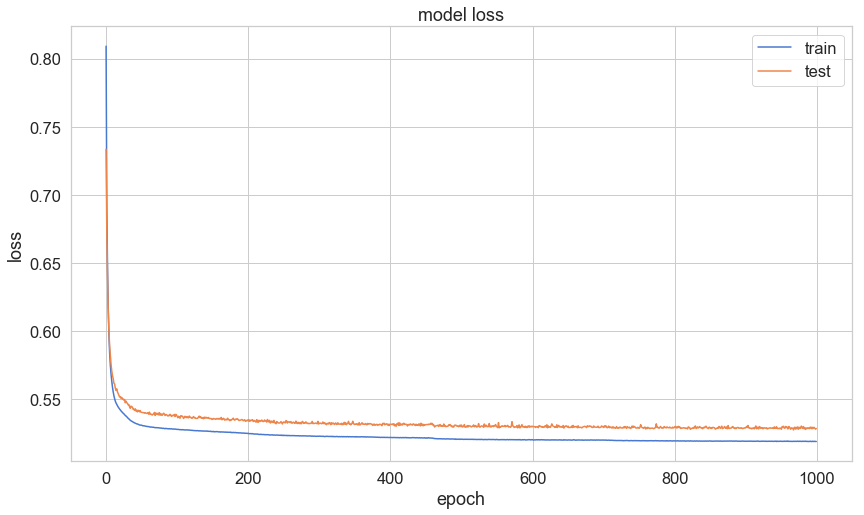

In [227]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

The reconstruction error on our training and test data seems to converge nicely. Is it low enough? Let's have a closer look at the error distribution:

In [228]:
predictions = autoencoder.predict(X_test)

In [229]:
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})

In [230]:
error_df.describe()

,reconstruction_error,true_class
count,7469.000000,7469.000000
mean,0.519098,0.047530
std,0.319460,0.212783
min,0.064211,0.000000
25%,0.295365,0.000000
50%,0.446413,0.000000
75%,0.653934,0.000000
max,3.538684,1.000000


### Reconstruction Error [Normal]

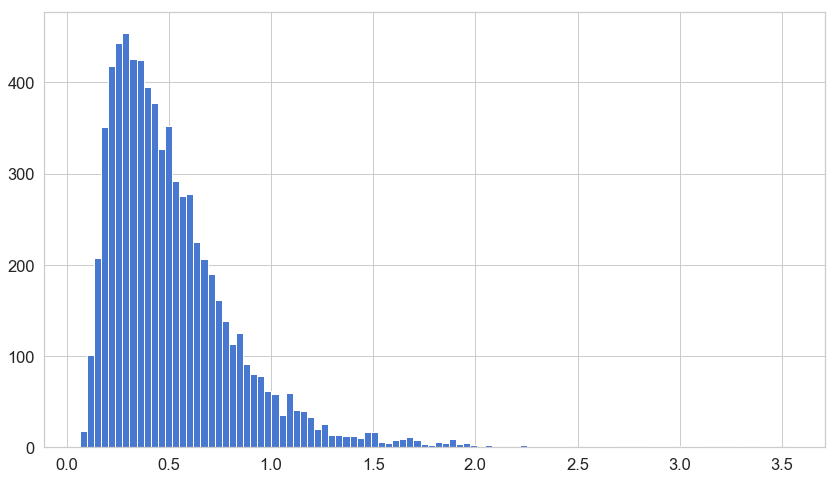

In [231]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[error_df['true_class']== 0]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=100)

### Reconstruction Error [Outliers]

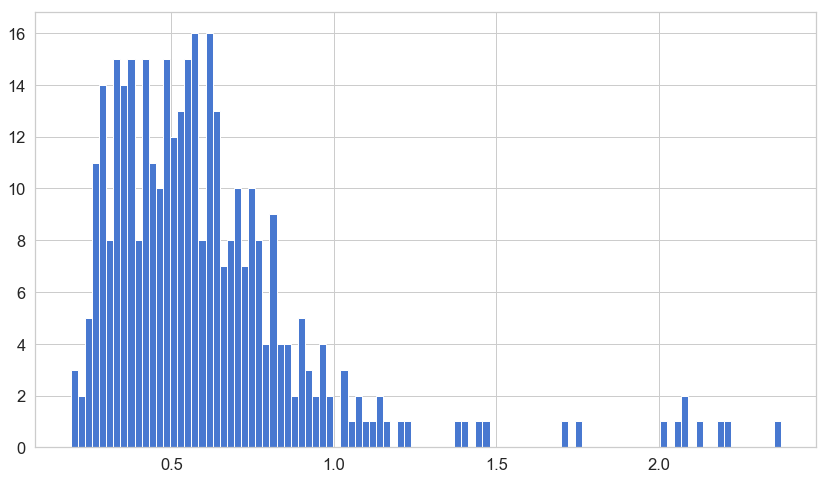

In [232]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=100)

In [233]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

ROC curves are very useful tool for understanding the performance of binary classifiers. However, our case is a bit out of the ordinary. We have a very imbalanced dataset. Nonetheless, let's have a look at our ROC curve:

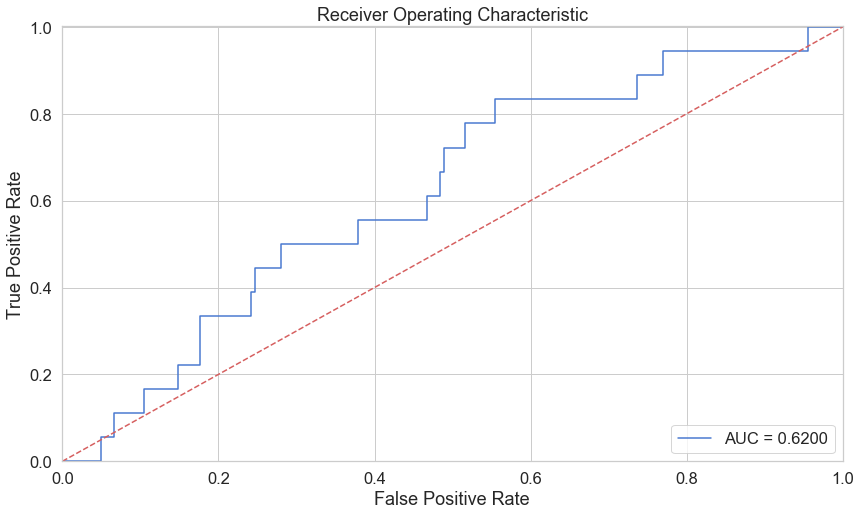

In [189]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

The ROC curve plots the true positive rate versus the false positive rate, over different threshold values. Basically, we want the blue line to be as close as possible to the upper left corner. While our results look pretty good, we have to keep in mind of the nature of our dataset. ROC doesn't look very useful for us.

### Precision vs Recall

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/350px-Precisionrecall.svg.png" />

Precision and recall are defined as follows:

$$\text{Precision} = \frac{\text{true positives}}{\text{true positives} + \text{false positives}}$$

$$\text{Recall} = \frac{\text{true positives}}{\text{true positives} + \text{false negatives}}$$

Let's take an example from Information Retrieval in order to better understand what precision and recall are. Precision measures the relevancy of obtained results. Recall, on the other hand, measures how many relevant results are returned. Both values can take values between 0 and 1. You would love to have a system with both values being equal to 1.

Let's return to our example from Information Retrieval. High recall but low precision means many results, most of which has low or no relevancy. When precision is high but recall is low we have the opposite - few returned results with very high relevancy. Ideally, you would want high precision and high recall - many results with that are highly relevant.

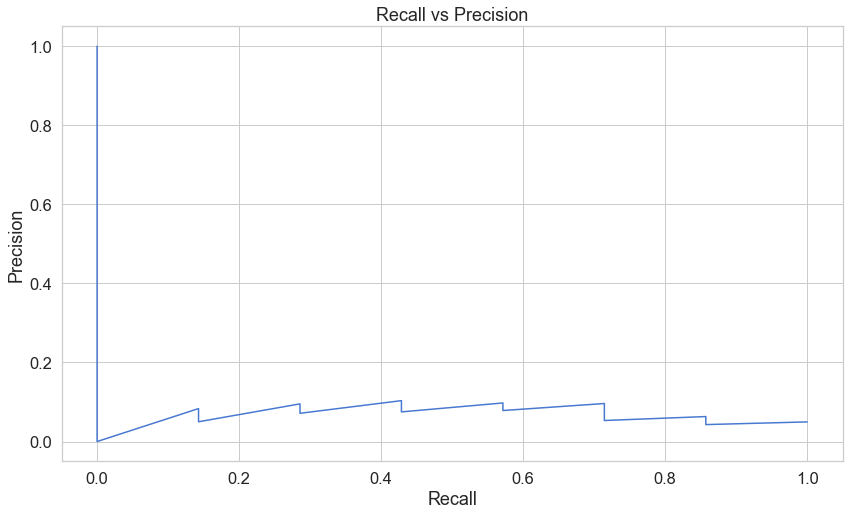

In [99]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate. High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall).

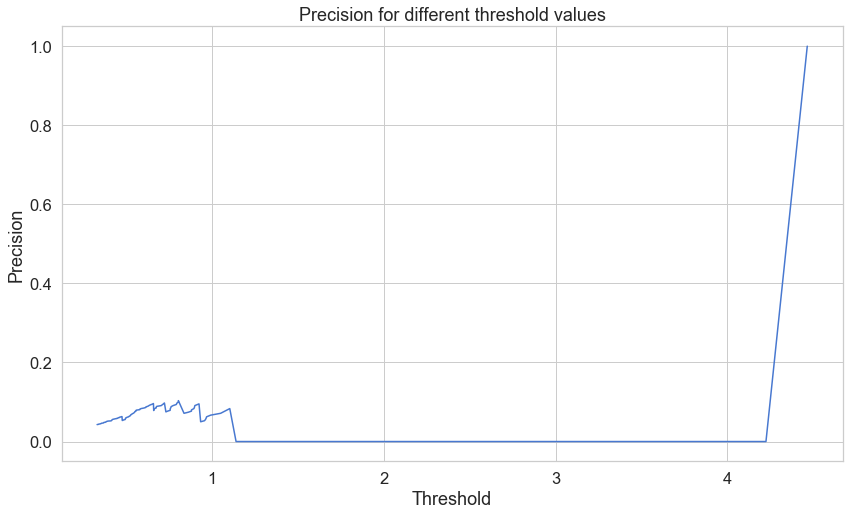

In [100]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

You can see that as the reconstruction error increases our precision rises as well. Let's have a look at the recall:

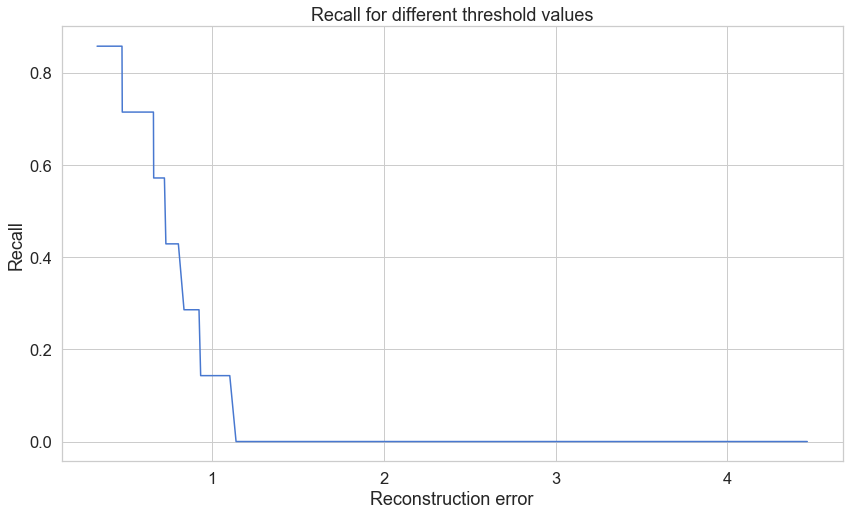

In [101]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

Here, we have the exact opposite situation. As the reconstruction error increases the recall decreases.

# Prediction

Our model is a bit different this time. It doesn't know how to predict new values. But we don't need that. In order to predict whether or not a new/unseen transaction is normal or fraudulent, we'll calculate the reconstruction error from the transaction data itself. If the error is larger than a predefined threshold, we'll mark it as a fraud (since our model should have a low error on normal transactions). Let's pick that value:

In [190]:
threshold = 2.0

And see how well we're dividing the two types of transactions:

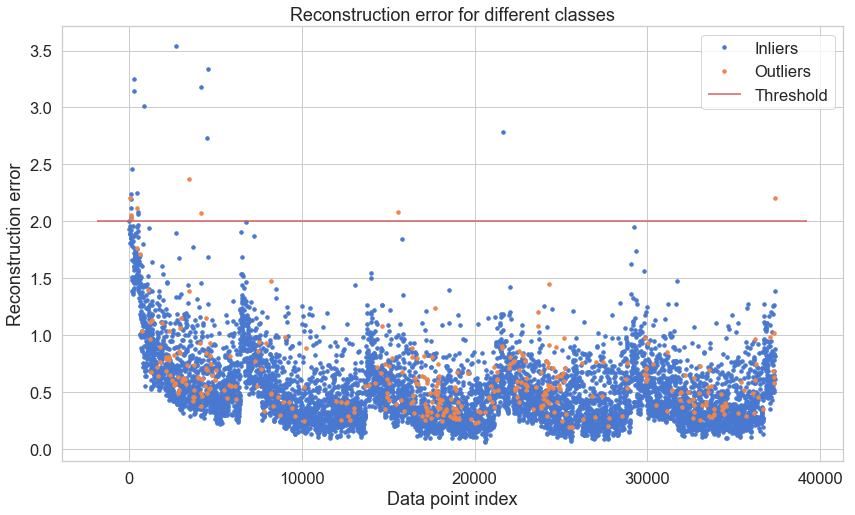

In [234]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label="Outliers" if name == 1 else "Inliers")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

#### Confusion Matrix

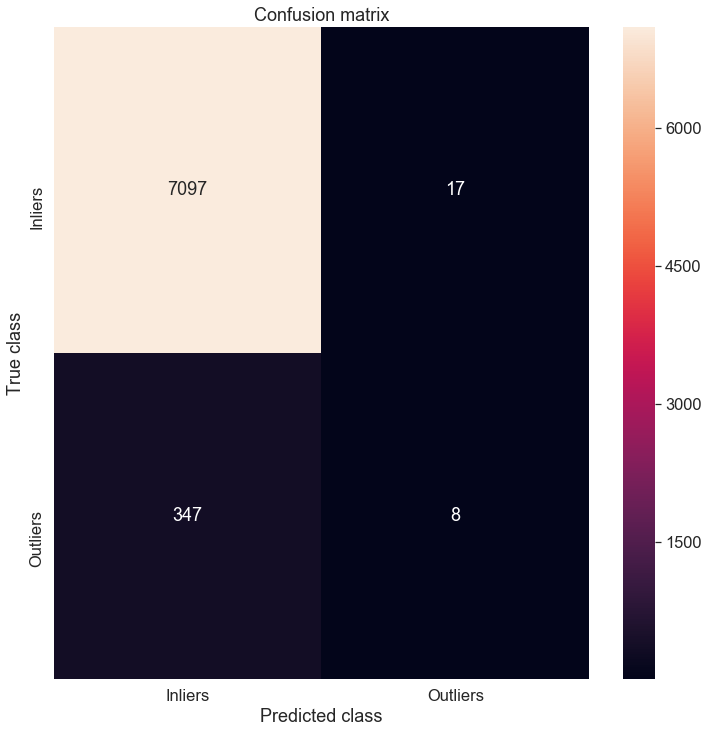

In [235]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()